In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [27]:
import numpy as np
import pandas as pd
from datetime import datetime
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#viewing the column names,types in measurement table
inspector=inspect(engine)
columns=inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
#viewing the column names,types in station table
inspector=inspect(engine)
columns=inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [174]:
#visualise data in df
stmt = (
    session
    .query(Measurement)
    .order_by(Measurement.date.desc())
    .statement
)
df.head()

,id,station,date,prcp,tobs
0,2724,USC00519397,2017-08-23,0.00,81.0
1,7635,USC00514830,2017-08-23,0.00,82.0
2,12187,USC00519523,2017-08-23,0.08,82.0
3,19550,USC00516128,2017-08-23,0.45,76.0
4,2723,USC00519397,2017-08-22,0.00,82.0


In [52]:
#visualise data in df
stmt = (
    session
    .query(Station)
    .order_by(Station.id.asc())
    .statement
)

df = pd.read_sql_query(stmt, session.bind)
df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [12]:
# Find the most recent date in the data set.
last_date=session.query(Measurement.date).group_by(Measurement.date).order_by((Measurement.date).desc()).first()
last_date=last_date.date
last_date

'2017-08-23'

In [112]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
last_year = datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)


In [116]:
# Perform a query to retrieve the data and precipitation scores
last_year_prcp = (session.query(Measurement.date,func.avg(Measurement.prcp)).filter(Measurement.date>last_year).
                 group_by(Measurement.date).all())

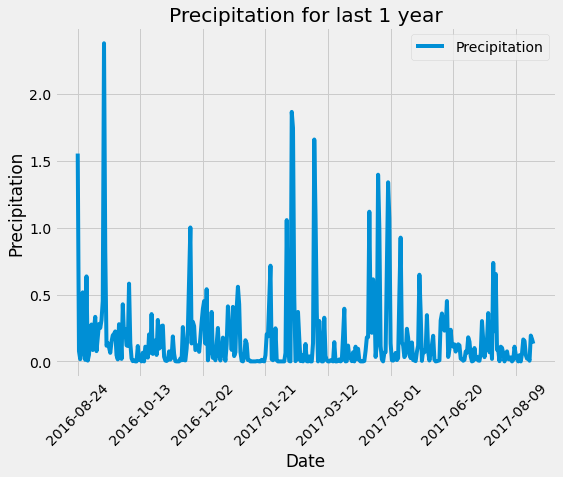

In [117]:
# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_prcp_df = pd.DataFrame(last_year_prcp, columns=['Date', 'Precipitation']).set_index('Date')
last_year_prcp_df

# Sort the dataframe by date
last_year_prcp_df.sort_values(by=['Date'],inplace=True,ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
last_year_prcp_df.plot(title="Precipitation for last 1 year",figsize=(8,6))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.show()


In [119]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_prcp_df.describe()
# or
mean_prcp = print(f"Mean Precipitaton: {round(last_year_prcp_df.Precipitation.mean(),2)}")
median_prcp = print(f"Median Precipitaton: {round(last_year_prcp_df.Precipitation.median(),2)}")
var_prcp = print(f"Precipitaton Variance: {round(last_year_prcp_df.Precipitation.var(),2)}")
std_prcp = print(f"Precipitaton Standard Deviation: {round(last_year_prcp_df.Precipitation.std(),2)}")
sem_prcp = print(f"Precipitaton SEM: {round(last_year_prcp_df.Precipitation.sem(),2)}")

Mean Precipitaton: 0.17
Median Precipitaton: 0.07
Precipitaton Variance: 0.09
Precipitaton Standard Deviation: 0.3
Precipitaton SEM: 0.02


# Exploratory Station Analysis

In [58]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [128]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations = (session.query(Measurement.id,Measurement.station,Station.name,func.count(Measurement.station)).
            filter(Measurement.station==Station.station).
           group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all())
stations

[(12188, 'USC00519281', 'WAIHEE 837.5, HI US', 2772),
 (1, 'USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 (2725, 'USC00513117', 'KANEOHE 838.1, HI US', 2709),
 (9519, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 (16939, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 (5434, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 (14960, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 (7636, 'USC00517948', 'PEARL CITY, HI US', 1372),
 (9008, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [133]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
tobs = (session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),
                      func.max(Measurement.tobs)).filter(Measurement.station=='USC00519281').all())
tobs

[(54.0, 71.66378066378067, 85.0)]

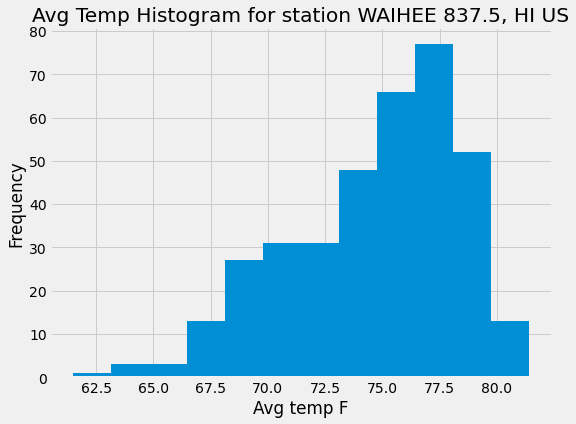

In [191]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_tobs = (session.query(Measurement.date,func.avg(Measurement.tobs)).filter(Measurement.date>last_year).
                 group_by(Measurement.date).all())
last_year_tobs_df = pd.DataFrame(last_year_tobs, columns=['Date','Avg Temperature F']).set_index('Date')
last_year_tobs_df.hist(figsize=(8,6),bins=12)
plt.xlabel('Avg temp F')
plt.ylabel('Frequency')
plt.title('Avg Temp Histogram for station WAIHEE 837.5, HI US')
plt.show()

# Close session

In [189]:
# Close Session
session.close()